In [1]:
import pandas as pd

In [2]:
amazon_labeled=pd.read_csv('SIHN/amazon_labeled.csv')

In [3]:
amazon_labeled=amazon_labeled.sample(frac=1).reset_index(drop=True)

In [4]:
print("Sentiments Distribution:\n",amazon_labeled['Ratings'].value_counts())

Sentiments Distribution:
 5    252
4    153
3     75
1     69
2     50
Name: Ratings, dtype: int64


In [5]:
amazon_unaugmented=pd.read_csv('SIHN/amazon_unaugmented.csv')
amazon_augmented=pd.read_csv('SIHN/amazon_augmented.csv')
print("Length of unaugmented data:",len(amazon_unaugmented))
print("Length of augmented data:",len(amazon_augmented))

Length of unaugmented data: 2999
Length of augmented data: 2999


In [6]:
binary_list=[]
for i in range(len(amazon_labeled)):
    if amazon_labeled.Ratings[i] >3:
        binary_list.append(1)
    elif amazon_labeled.Ratings[i] <=3: 
        binary_list.append(0)

In [7]:
amazon_labeled['Sentiments']=binary_list

In [8]:
print("Sentiment Distribution:")
print(amazon_labeled['Sentiments'].value_counts())

Sentiment Distribution:
1    405
0    194
Name: Sentiments, dtype: int64


In [9]:
import pandas as pd
import numpy as np
import re
import time
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import Normalizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import seaborn as sns
import nltk
nltk.download('punkt')
from gensim.models import FastText as ft

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def text_preprocess(text):
    text=re.sub('\n','',text)
    text=text.lower()
    text=re.sub(r'[^\w]', ' ',text)
    text=re.sub('<br>','',text)
    text=re.sub(r'\s([?.!"](?:\s|$))', r'\1', text)
    text=re.sub('[^.,a-zA-Z0-9 \n\.]', '', text)
    return text

In [11]:
def word_embeddings(reviews):
    first_review=reviews[0]
    first_tokenized_review=nltk.word_tokenize(first_review)
    first_review_vectors=word_embeddings_model.wv[first_tokenized_review]
    first_review_vectors_mean=np.mean(first_review_vectors,axis=0)
    first_review_vectors_mean=first_review_vectors_mean.reshape(1,-1)
    final_review_vectors_mean=first_review_vectors_mean
    for i in range(1,len(reviews)):
        review=reviews[i]
        review_tokens=nltk.word_tokenize(review)
        review_vector=word_embeddings_model.wv[review_tokens]
        review_vector_mean=np.mean(review_vector,axis=0)
        review_vector_mean=review_vector_mean.reshape(1,-1)
        final_review_vectors_mean=np.concatenate((final_review_vectors_mean,review_vector_mean))
    return final_review_vectors_mean

In [12]:
word_embeddings_model=ft.load_fasttext_format("cc.en.300.bin")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [14]:
def repeat_dataloader(iteralbe):
        """ repeat dataloader """
        while True:
            for x in iteralbe:
                yield x

In [15]:
Xtrain, Xtest, Ytrain, Ytest =train_test_split(amazon_labeled['Reviews'],amazon_labeled['Sentiments'])

In [16]:
Xtrain=Xtrain.reset_index(drop=True)
supervised_train_x_reviews=Xtrain

In [17]:
Xtest=Xtest.reset_index(drop=True)
eval_test_x_reviews=Xtest

In [18]:
Ytrain=Ytrain.reset_index(drop=True)
Ytest=Ytest.reset_index(drop=True)

In [19]:
unaugmented_x=pd.read_csv('SIHN/amazon_unaugmented.csv')
augmented_x=pd.read_csv('SIHN/amazon_augmented.csv')

In [20]:
print("Length of unaugmented data:",len(unaugmented_x))
print("Length of augmented data:",len(augmented_x))

Length of unaugmented data: 2999
Length of augmented data: 2999


In [21]:
unaugmented_x=unaugmented_x['Reviews']
augmented_x=augmented_x['Reviews']
supervised_train_y=Ytrain
eval_test_y=Ytest

In [22]:
supervised_train_x_reviews=supervised_train_x_reviews.map(lambda com : text_preprocess(com))
eval_test_x_reviews=eval_test_x_reviews.map(lambda com : text_preprocess(com))
unaugmented_x=unaugmented_x.map(lambda com : text_preprocess(com))
augmented_x=augmented_x.map(lambda com : text_preprocess(com))

In [23]:
print(len(augmented_x),len(augmented_x))

2999 2999


In [24]:
indexes=[]
for i in range(len(augmented_x)):
    if not augmented_x[i].strip():
        indexes.append(i)

In [25]:
for i in indexes:
    del augmented_x[i]

In [26]:
for j in indexes:
    del unaugmented_x[j]

In [27]:
unaugmented_x=unaugmented_x.reset_index(drop=True)
augmented_x=augmented_x.reset_index(drop=True)

In [28]:
print(len(unaugmented_x),len(augmented_x))

2996 2996


In [29]:
supervised_train_x_vectors=word_embeddings(supervised_train_x_reviews)
eval_test_x_vectors=word_embeddings(eval_test_x_reviews)
unaugmented_x_vectors=word_embeddings(unaugmented_x)
augmented_x_vectors=word_embeddings(augmented_x)

In [30]:
augmented_x_vectors.shape

(2996, 300)

In [31]:
supervised_train_x_vectors=supervised_train_x_vectors.astype(float)
eval_test_x_vectors=eval_test_x_vectors.astype(float)
unaugmented_x_vectors=unaugmented_x_vectors.astype(float)
augmented_x_vectors=augmented_x_vectors.astype(float)
supervised_train_y_vectors=supervised_train_y.values
eval_test_y_vectors=eval_test_y.values
supervised_train_y_vectors=supervised_train_y_vectors.astype(float)
eval_test_y_vectors=eval_test_y_vectors.astype(float)
supervised_train_y_vectors=supervised_train_y_vectors.reshape(-1,1)
eval_test_y_vectors=eval_test_y_vectors.reshape(-1,1)

In [32]:
supervised_xtrain_tensor=torch.tensor(supervised_train_x_vectors,dtype=torch.float)
eval_xtest_tensor=torch.tensor(eval_test_x_vectors,dtype=torch.float)
supervised_ytrain_tensor=torch.tensor(supervised_train_y_vectors,dtype=torch.float)
eval_ytest_tensor=torch.tensor(eval_test_y_vectors,dtype=torch.float)
unaugmented_x_tensor=torch.tensor(unaugmented_x_vectors,dtype=torch.float)
augmented_x_tensor=torch.tensor(augmented_x_vectors,dtype=torch.float)

In [33]:
print(supervised_xtrain_tensor.shape)
print(supervised_ytrain_tensor.shape)

torch.Size([449, 300])
torch.Size([449, 1])


In [34]:
class NNClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, input_size, output_size):
        super(NNClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)  
            
    def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred

In [35]:
input_size=supervised_xtrain_tensor.size()[1]
output_size=1

In [36]:
model=NNClassifier(input_size,output_size)
num_epochs=100
sup_criterion = nn.BCELoss(reduction='mean')
unsup_criterion= nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [37]:
supervised_train_data = TensorDataset(supervised_xtrain_tensor , supervised_ytrain_tensor)
#print(supervised_train_data[2])

In [38]:
unsupervised_train_data = TensorDataset(unaugmented_x_tensor , augmented_x_tensor)
#print(unsupervised_train_data[15])

In [39]:
supervised_train_batch_size=25
unsupervised_ratio=3
unsupervised_train_batch_size=supervised_train_batch_size * unsupervised_ratio

In [40]:
supervised_train_loader = DataLoader(dataset=supervised_train_data, batch_size=supervised_train_batch_size, shuffle=True)

In [41]:
unsupervised_train_loader= DataLoader(dataset=unsupervised_train_data, batch_size=unsupervised_train_batch_size, shuffle=True)

In [42]:
len(supervised_train_loader)

18

In [43]:
len(unsupervised_train_loader)

40

In [44]:
supervised_train_loader=repeat_dataloader(supervised_train_loader)

In [45]:
def get_loss(model,sup_batch,unsup_batch,sup_crtiterion,unsup_criterion,weight_factor):
    pred_prob=model(sup_batch[0])
    #print(pred_prob)
    #sup_batch[1]=sup_batch[1].reshape(-1)
    sup_loss=sup_criterion(pred_prob,sup_batch[1])
    aug_prob=model(unsup_batch[0])
    unaug_prob=model(unsup_batch[1])
    unsup_loss=unsup_criterion(aug_prob,unaug_prob)
    final_loss = sup_loss + (weight_factor * unsup_loss)
    return sup_loss,unsup_loss,final_loss

In [46]:
def get_accuracy(actual,predicted):
    actual=actual.numpy()
    pred_list=[]
    for i in range(len(predicted)):
        p=predicted[i].reshape(1,-1)
        for j in range(len(p)):
            if p[j]>0.5:
                pred_list.append(1)
            elif p[j]<0.5:
                pred_list.append(0)
    return accuracy_score(actual,pred_list)

In [47]:
for epoch in range(num_epochs):
    for i,batch in enumerate(unsupervised_train_loader):
        unsup_batch=[t for t in batch]
        sup_batch=[t for t in next(supervised_train_loader)]
        

In [48]:
model(sup_batch[0][0])

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.5249], grad_fn=<SigmoidBackward>)

In [64]:
train_accuracy_list=[]
test_accuracy_list=[]
start_time = time.time()
final_loss_list=[]
final_loss_avg_list=[]
eval_loss_list=[]
list1=[]
list2=[]
sup_loss_list=[]
unsup_loss_list=[]
num_epochs=200
output_losses=[]
model_list=[]
outputs=[]
for epoch in range(num_epochs):
    for i,batch in enumerate(unsupervised_train_loader):
        unsup_batch=[t for t in batch]
        sup_batch=[t for t in next(supervised_train_loader)]
        optimizer.zero_grad()
        weight_factor=1
        sup_loss,unsup_loss,final_loss=get_loss(model,sup_batch,unsup_batch,sup_criterion,unsup_criterion,weight_factor)
        list1.append(sup_loss.item())
        list2.append(unsup_loss.item())
        final_loss_list.append(final_loss.item())
        final_loss.backward()
        optimizer.step()
    sup_loss_list.append(sum(list1) / len(list1))
    unsup_loss_list.append(sum(list2) / len(list2))
    list1=[]
    if epoch % 1 == 0:
        train_inputs=supervised_xtrain_tensor
        train_true=supervised_ytrain_tensor
        train_true=train_true.reshape(-1)
        train_outputs=model(train_inputs)
        train_accuracy=get_accuracy(train_true,train_outputs) 
        train_accuracy_list.append(train_accuracy)        
        test_inputs=eval_xtest_tensor
        test_true=eval_ytest_tensor
        test_true=test_true.reshape(-1)        
        eval_test_outputs=model(eval_xtest_tensor)
        outputs.append(eval_test_outputs)
        eval_loss=sup_criterion(eval_test_outputs,test_true)  
        #print("Val loss: {:.4f}".format(eval_loss.item()))
        checkpoint = {'model': NNClassifier(input_size,output_size),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'checkpoint.pth')
        model_list.append(load_checkpoint('checkpoint.pth'))        
        test_accuracy=get_accuracy(test_true,eval_test_outputs) 
        test_accuracy_list.append(test_accuracy)
        #print("Epoch: {}, val_loss: {:.4f} Accuracy: {:.4f}".format(epoch,eval_loss.item(),accuracy))        
        print("Epoch: {}, train_accuray: {:.4f} test_accuracy: {:.4f}".format(epoch,train_accuracy,test_accuracy))
        eval_loss_list.append(eval_loss.item())        
print("\nModel Training Time : --- %s seconds ---" % (time.time() - start_time))        

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type NNClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 1, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 2, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 3, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 4, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 5, train_accuray: 0.7350 test_accuracy: 0.6600
Epoch: 6, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 7, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 8, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 9, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 10, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 11, train_accuray: 0.7350 test_accuracy: 0.6533
Epoch: 12, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 13, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 14, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 15, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 16, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 17, train_accuray: 0.7372 test_accuracy: 0.6600
Epoch: 18, train_acc

Epoch: 150, train_accuray: 0.7572 test_accuracy: 0.6533
Epoch: 151, train_accuray: 0.7528 test_accuracy: 0.6533
Epoch: 152, train_accuray: 0.7528 test_accuracy: 0.6533
Epoch: 153, train_accuray: 0.7528 test_accuracy: 0.6533
Epoch: 154, train_accuray: 0.7528 test_accuracy: 0.6533
Epoch: 155, train_accuray: 0.7572 test_accuracy: 0.6533
Epoch: 156, train_accuray: 0.7550 test_accuracy: 0.6533
Epoch: 157, train_accuray: 0.7528 test_accuracy: 0.6533
Epoch: 158, train_accuray: 0.7572 test_accuracy: 0.6533
Epoch: 159, train_accuray: 0.7528 test_accuracy: 0.6533
Epoch: 160, train_accuray: 0.7572 test_accuracy: 0.6533
Epoch: 161, train_accuray: 0.7506 test_accuracy: 0.6533
Epoch: 162, train_accuray: 0.7550 test_accuracy: 0.6533
Epoch: 163, train_accuray: 0.7550 test_accuracy: 0.6533
Epoch: 164, train_accuray: 0.7550 test_accuracy: 0.6533
Epoch: 165, train_accuray: 0.7550 test_accuracy: 0.6533
Epoch: 166, train_accuray: 0.7506 test_accuracy: 0.6533
Epoch: 167, train_accuray: 0.7572 test_accuracy:

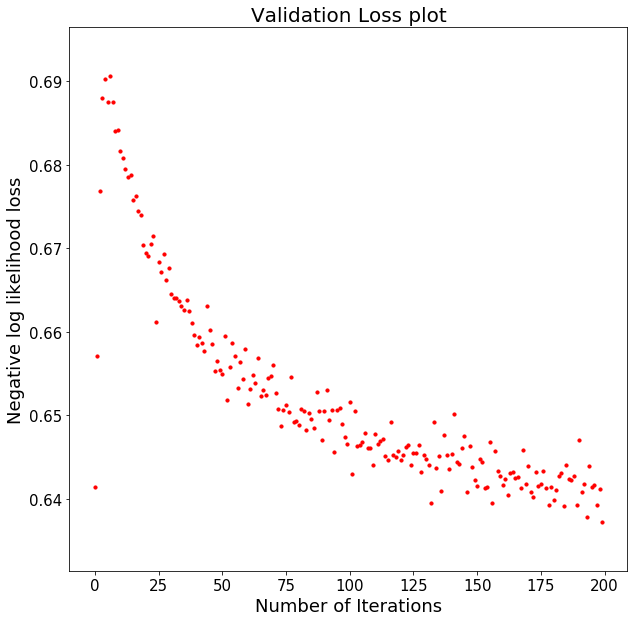

In [50]:
test_epoch=[x for x in range(0,len(eval_loss_list),1)]
plt.figure(figsize=(10,10))
plt.title("Validation Loss plot",size=20)
plt.xlabel("Number of Iterations",size=18)
plt.ylabel("Negative log likelihood loss",size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.scatter(test_epoch,eval_loss_list,color='r',s=10,marker='o')
plt.plot(labels='loss')
plt.show()

Maximum Training Accuracy: 0.734966592427617


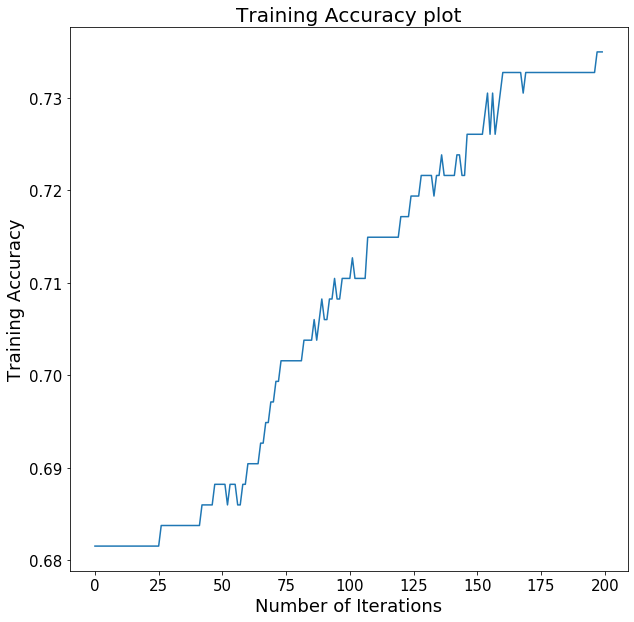

In [51]:
train_accuracy_epoch=[x for x in range(0,len(train_accuracy_list),1)]
plt.figure(figsize=(10,10))
plt.title("Training Accuracy plot",size=20)
plt.xlabel("Number of Iterations",size=18)
plt.ylabel("Training Accuracy",size=18)
plt.xticks(size=15)
plt.yticks(size=15)
print("Maximum Training Accuracy:",max(train_accuracy_list))
plt.plot(train_accuracy_epoch,train_accuracy_list)
plt.show()

Maximum Validation Accuracy: 0.66


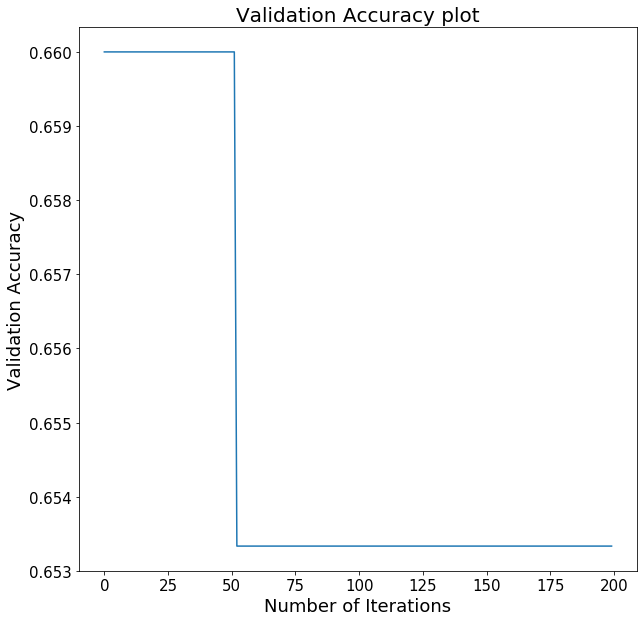

In [52]:
test_accuracy_epoch=[x for x in range(0,len(test_accuracy_list),1)]
plt.figure(figsize=(10,10))
plt.title("Validation Accuracy plot",size=20)
plt.xlabel("Number of Iterations",size=18)
plt.ylabel("Validation Accuracy",size=18)
plt.xticks(size=15)
plt.yticks(size=15)
print("Maximum Validation Accuracy:",max(test_accuracy_list))
plt.plot(test_accuracy_epoch,test_accuracy_list)
plt.show()

In [53]:
def best_model_trained_index(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs
print("Best model indexes for training are:",best_model_trained_index(train_accuracy_list,max(train_accuracy_list)))
print("Best model indexes for validation are:",best_model_trained_index(test_accuracy_list,max(test_accuracy_list)))
#model_index_list=best_model_trained_index(accuracy_list,max(accuracy_list))
#best_model_index=model_index_list[0]

Best model indexes for training are: [197, 198, 199]
Best model indexes for validation are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [54]:
train_acc=list(set(train_accuracy_list))
top_idx_train = np.argsort(train_acc)[-4:]
top_values_train = [train_acc[i] for i in top_idx_train]
test_acc=list(set(test_accuracy_list))
top_idx_test = np.argsort(test_acc)[-4:]
top_values_test = [test_acc[i] for i in top_idx_test]
print("Top training accuracies from model are:",top_values_train)
print("\n")
print("Top validation accuracies from model are:",top_values_test)

Top training accuracies from model are: [0.7282850779510023, 0.7305122494432071, 0.732739420935412, 0.734966592427617]


Top validation accuracies from model are: [0.6533333333333333, 0.66]


In [55]:
print("Training:",best_model_trained_index(train_accuracy_list,0.7416481069042317))
print("Validation:",best_model_trained_index(test_accuracy_list,0.74))

Training: []
Validation: []


In [59]:
train_predictions=model_list[171](supervised_xtrain_tensor)
actual=supervised_ytrain_tensor
actual=actual.reshape(-1)
actual=actual.numpy()
train_pred_list=[]
for i in range(len(train_predictions)):
    p=train_predictions[i].reshape(1,-1)
    values,indices=torch.max(p,dim=1)
    train_pred_list.append(indices.item())
print("Predicted Results of Training:")
print("\nAccuracy of the model is:{:.4f}".format(accuracy_score(actual,train_pred_list)))
print("\n")
print("\nClassification report:")
print(classification_report(actual,train_pred_list))
print("Confusion matrix:")
labels=['negative','positive','neutral','no_aspect']
cm=confusion_matrix(actual,train_pred_list)
print("\n")
print(cm)
print("\n")
from sklearn.metrics.classification import f1_score
print("\nThe average weighted f1 score of the model is: {:.4f}".format(f1_score(actual,train_pred_list,average='weighted')))
print("\nThe average micro f1 score of the model is: {:.4f}".format(f1_score(actual,train_pred_list,average='micro')))
print("\nThe average macro f1 score of the model is: {:.4f}".format(f1_score(actual,train_pred_list,average='macro')))


Predicted Results of Training:

Accuracy of the model is:0.3185



Classification report:
              precision    recall  f1-score   support

         0.0       0.32      1.00      0.48       143
         1.0       0.00      0.00      0.00       306

    accuracy                           0.32       449
   macro avg       0.16      0.50      0.24       449
weighted avg       0.10      0.32      0.15       449

Confusion matrix:


[[143   0]
 [306   0]]



The average weighted f1 score of the model is: 0.1539

The average micro f1 score of the model is: 0.3185

The average macro f1 score of the model is: 0.2416


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
eval_test_y[25]

1

In [62]:
print('Review:\n',eval_test_x_reviews[25])
print('\n')
print('Sentiment:\n',eval_test_y[25])

Review:
 i am reviewing this on behalf of my boyfriend who is the lucky user of this electric shaver  he still insists that razor a blade gives a closer shave and i agree  the skin is a lot smoother and clearer but this is great for the weekends when he wants to get rid of the stubble and not scratch my face off  this enables him to get a smooth feeling on the skin without stripping and irritating it  and no creams and products are needed  the 3 rotating heads really adjust to the contour of the face and they snap open for easy clean up with water  i ve seen him use it and it s a cinch  fast  easy and no mess overall this is a great product  it works well and the face feels and looks good afterwards and it takes very little time to use  better than shaving when it comes to comfort but my man still prefers the razor when he has to shave for work  this makes a great holiday gift  a gadget that people wouldn t run out and buy for themselves necessarily and fun to have as an option in the 

In [63]:
test_predictions=model_list[191](eval_xtest_tensor)
actual=eval_ytest_tensor
actual=actual.reshape(-1)
actual=actual.numpy()
pred_list=[]
for i in range(len(test_predictions)):
    p=test_predictions[i].reshape(1,-1)
    values,indices=torch.max(p,dim=1)
    pred_list.append(indices.item())
print("Predicted Results of Validation:")
print("\nAccuracy of the model is:{:.4f}".format(accuracy_score(actual,pred_list)))
print("\n")
print("Number of negative aspects:",pred_list.count(0))
print("Number of positive aspects:",pred_list.count(1))
print("Number of neutral aspects:",pred_list.count(2))
print("Number of no prescence aspects:",pred_list.count(3))
print("\nClassification report:")
print(classification_report(actual,pred_list))
print("Confusion matrix:")
labels=['negative','positive','neutral','no_aspect']
cm=confusion_matrix(actual,pred_list)
print("\n")
print(cm)
print("\n")
from sklearn.metrics.classification import f1_score
print("The average f1 score of the model is: {:.4f}".format(f1_score(actual,pred_list,average='weighted')))

Predicted Results of Validation:

Accuracy of the model is:0.3400


Number of negative aspects: 150
Number of positive aspects: 0
Number of neutral aspects: 0
Number of no prescence aspects: 0

Classification report:
              precision    recall  f1-score   support

         0.0       0.34      1.00      0.51        51
         1.0       0.00      0.00      0.00        99

    accuracy                           0.34       150
   macro avg       0.17      0.50      0.25       150
weighted avg       0.12      0.34      0.17       150

Confusion matrix:


[[51  0]
 [99  0]]


The average f1 score of the model is: 0.1725


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
